## With H20:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
import h2o
from h2o.automl import H2OAutoML

In [2]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Zulu11.43+55-CA (build 11.0.9.1+1-LTS, mixed mode)
  Starting server from C:\Users\liorn\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\liorn\AppData\Local\Temp\tmpa5f2xcsn
  JVM stdout: C:\Users\liorn\AppData\Local\Temp\tmpa5f2xcsn\h2o_liorn_started_from_python.out
  JVM stderr: C:\Users\liorn\AppData\Local\Temp\tmpa5f2xcsn\h2o_liorn_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Jerusalem
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,2 months and 2 days
H2O_cluster_name:,H2O_from_python_liorn_2hplcc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.934 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


# Classification

Pre-Processing included:

On CAN'd data:
* White spaces to nan

* `abn_pap` column - 99 to mode

* imputing missing values to modes

* new features - `weight_diff`, `num_of_prior_diseases`, `body_BMI`

* removed columns containing only zeros

On combined dataset:

* Removed sessions with duration of less than 5 minutes

* dropped columns - `body_meas_height`, `body_meas_bmi`, `body_meas_prior_pregnancy_weight`, `body_meas_prior_pregnancy_weight`, `mon_sess_time_zone_diff`, `mon_sess_date`, `mon_sess_start_time`, `on_sess_duration`, `dem_det_age`, `subject_id`, `session_id`, `current_weight_kg`, `weight_before_kg`, `current_height_cm`, `body_meas_current_weight`, `MasterID`.

* Dropped features with a high portion of missing values

* Configured LTI_STI features

* Filled missing values with means

* One-Hot encoded demographic features

* Dropped features with low cardinality

#### Importing data:

In [9]:
df_feats = pd.read_csv('df_feats.csv')

df_targets = pd.read_csv('df_targets.csv')

#### Training (5-Fold CV)

In [10]:
X = df_feats.drop(columns=['study_id'])

df_auto = pd.concat([X, df_targets["cesdclinmA"]], axis=1)

# converting to h20 data object
df_h2o = h2o.H2OFrame(df_auto)

# configuring y as binary target
y = "cesdclinmA"
df_h2o[y] = df_h2o[y].asfactor()

# training with 5Fold CV
aml_proc_clf = H2OAutoML(max_models = 10, seed = 1, nfolds=5, sort_metric='auc', keep_cross_validation_predictions=True)

aml_proc_clf.train(y = y, training_frame = df_h2o)

aml_proc_clf.leaderboard

Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
14:05:02.931: AutoML: XGBoost is not available; skipping it.

████████
14:05:09.16: Skipping training of model GBM_5_AutoML_20210722_140502 due to exception: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_5_AutoML_20210722_140502.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 47.0.


████████████████████████████████████████████████| 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GLM_1_AutoML_20210722_140502,0.785354,0.465317,0.537457,0.268939,0.390095,0.152174
GBM_4_AutoML_20210722_140502,0.770202,0.468764,0.451352,0.247475,0.401135,0.16091
GBM_3_AutoML_20210722_140502,0.752525,0.456526,0.452943,0.239899,0.390489,0.152481
DeepLearning_grid__1_AutoML_20210722_140502_model_1,0.712121,1.22779,0.348139,0.30303,0.491708,0.241776
GBM_2_AutoML_20210722_140502,0.70202,0.4957,0.387301,0.22601,0.412928,0.170509
StackedEnsemble_BestOfFamily_AutoML_20210722_140502,0.679293,0.513975,0.327689,0.313131,0.414453,0.171772
StackedEnsemble_AllModels_AutoML_20210722_140502,0.676768,0.516332,0.315992,0.323232,0.416249,0.173263
GBM_grid__1_AutoML_20210722_140502_model_1,0.661616,0.589822,0.289228,0.295455,0.441617,0.195025
DeepLearning_1_AutoML_20210722_140502,0.628788,1.24116,0.29467,0.320707,0.492434,0.242491
GBM_1_AutoML_20210722_140502,0.608586,0.744357,0.289129,0.354798,0.467944,0.218972


#### Top Model

In [11]:
top_model_proc = aml_proc_clf.leader
print(top_model_proc.model_id)
top_model_proc.summary()

GLM_1_AutoML_20210722_140502

GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,Ridge ( lambda = 0.05944 ),"nlambda = 30, lambda.max = 18.064, lambda.min = 0.05944, lambda.1s...",175,175,38,automl_training_py_41_sid_9f26


#### Top Model CV Results:

In [12]:
top_model_proc_cv_metrics = top_model_proc.cross_validation_metrics_summary().as_data_frame()
print(top_model_proc.model_id)
top_model_proc_cv_metrics

GLM_1_AutoML_20210722_140502


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.77111113,0.21337962,0.4,0.9,0.8888889,0.8888889,0.7777778
1,auc,0.70357144,0.2265887,0.375,0.8888889,0.64285713,0.9444444,0.6666667
2,err,0.22888888,0.21337962,0.6,0.1,0.11111111,0.11111111,0.22222222
3,err_count,2.2,2.1679482,6.0,1.0,1.0,1.0,2.0
4,f0point5,0.6249308,0.21534765,0.29411766,0.5555556,0.8333333,0.7894737,0.65217394
5,f1,0.66809523,0.16906103,0.4,0.6666667,0.6666667,0.85714287,0.75
6,f2,0.76674837,0.16706967,0.625,0.8333333,0.5555556,0.9375,0.88235295
7,lift_top_group,1.5,2.1213202,0.0,0.0,4.5,3.0,0.0
8,logloss,0.4592033,0.12743653,0.5159414,0.24481894,0.51305884,0.44988704,0.5723104
9,max_per_class_error,0.37222221,0.26028237,0.75,0.11111111,0.5,0.16666667,0.33333334


#### Top models vs Top features heatmap

In [13]:
# leaderboard to dataframe
leaderboard = aml_proc_clf.leaderboard.as_data_frame()

# getting feature names and sorting
column_names = [col for col, rel_imp, scal_imp, percent in top_model_proc.varimp()]
column_names.sort()

df_imp = pd.DataFrame(columns=column_names)

model_ids = []

for i in range(len(leaderboard)):
    
    # Accessing the information of each model in the leaderboard
    model_id = leaderboard.iloc[i]['model_id']
    
    if not model_id.startswith('Stacked'):
        
        model_ids.append(model_id)
        model = h2o.get_model(model_id)
    
        # getting the name and importance of each feature
        coefs = [(col, percent) for col, rel_imp, scal_imp, percent in model.varimp()]
    
        # sorting alphabetically to insert properly all the values to the dataframe
        coefs.sort()
        coefs = [percent for col, percent in coefs]
        # adding to dataframe
        df_len = len(df_imp)
        df_imp.loc[df_len] = coefs
    
df_imp['Model'] = model_ids
df_imp = df_imp.set_index(['Model'])

# normalizing coefficients
df_imp = df_imp.abs()
df_imp = (df_imp.T / df_imp.T.sum()).T

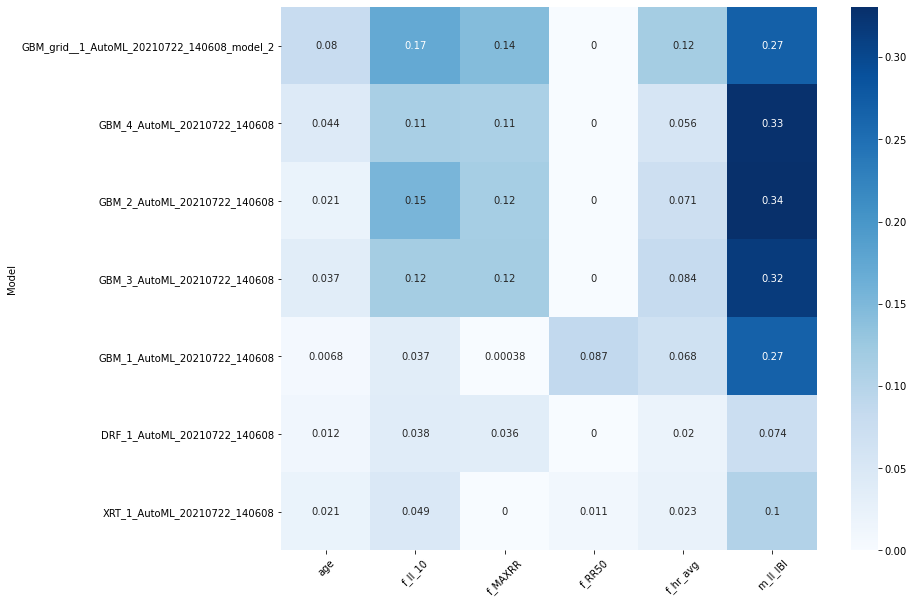

In [35]:
fig, ax = plt.subplots(figsize=(12,10))

# Filtering values
top_coefs = df_imp.loc[df_imp.max(axis=1) > 0.05, df_imp.max(axis=0) > 0.05]

sns.heatmap(top_coefs, robust=True, annot=True, cmap="Blues")
plt.savefig('heatmap_clf_Automl.png',bbox_inches="tight")
ax.set_xticklabels(top_coefs.columns, rotation=45)
plt.show()

#### Feature Importances of top 3 models

GLM_1_AutoML_20210722_140502


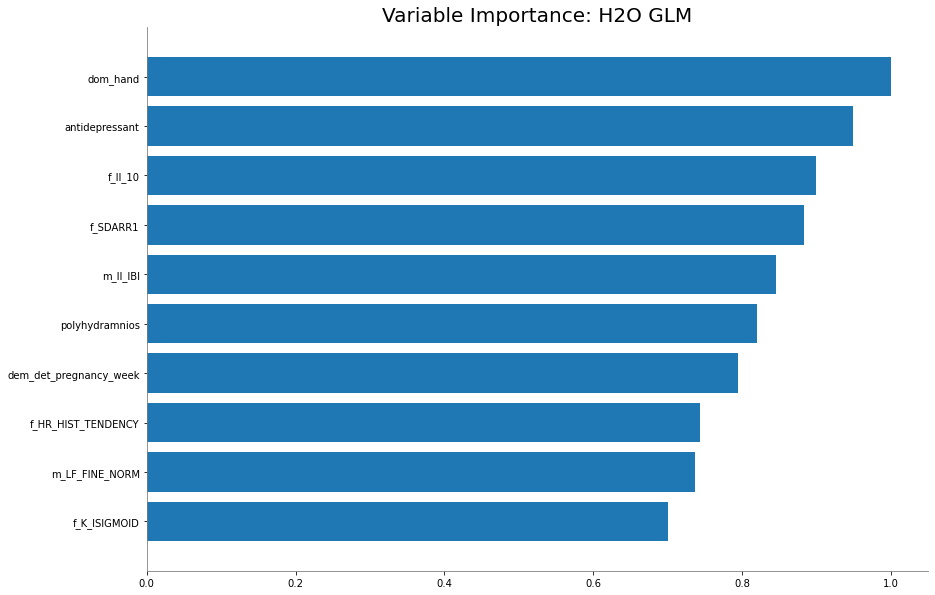

GBM_4_AutoML_20210722_140502


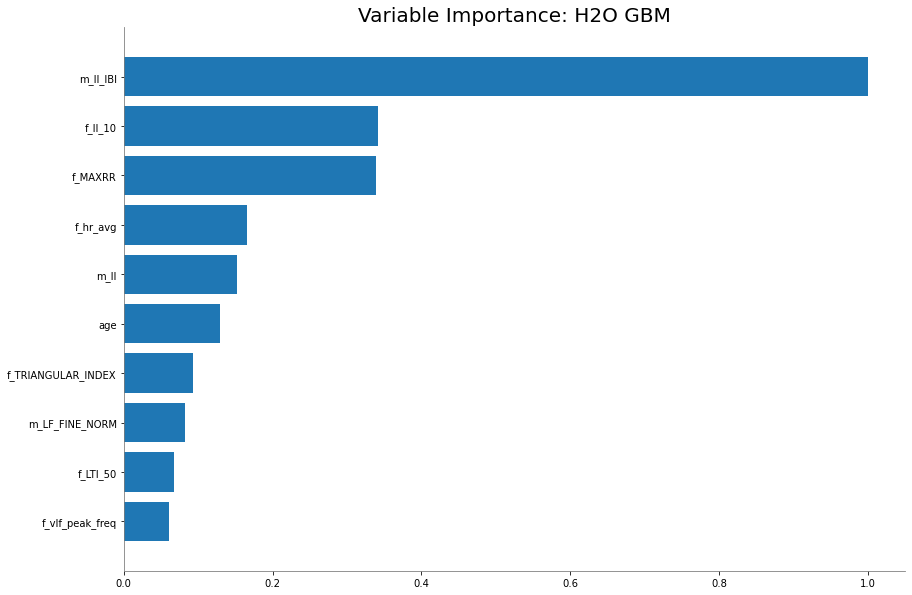

GBM_3_AutoML_20210722_140502


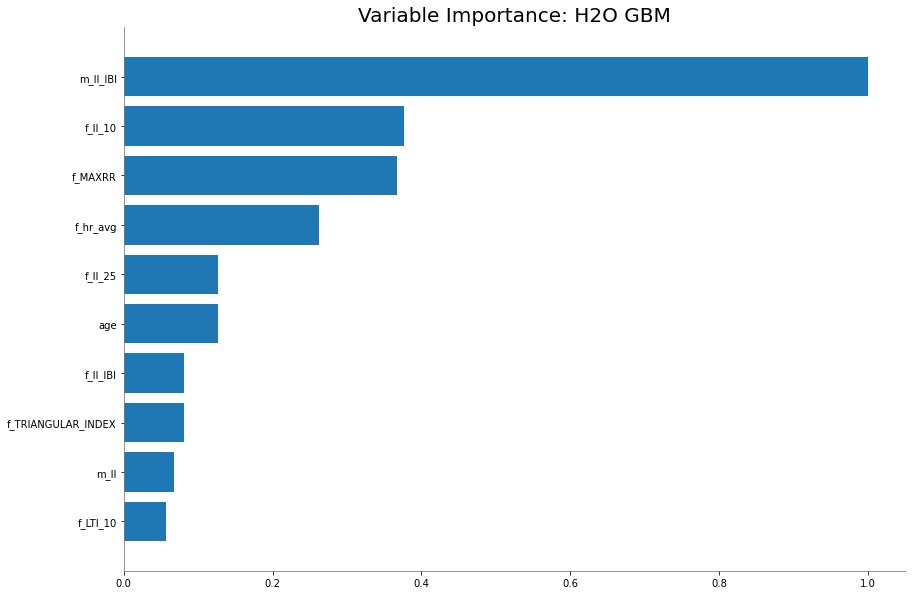

In [15]:
for i in range(3):
    m_id = leaderboard.iloc[i]['model_id']
    print(m_id)
    model = h2o.get_model(m_id)
    model.varimp_plot()

In [16]:
for i in range(3):
    m_id = leaderboard.iloc[i]['model_id']
    print(m_id)
    model = h2o.get_model(m_id)
    print(model.cross_validation_metrics_summary())

GLM_1_AutoML_20210722_140502

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.77111113,0.21337962,0.4,0.9,0.8888889,0.8888889,0.7777778
1,auc,0.70357144,0.2265887,0.375,0.8888889,0.64285713,0.9444444,0.6666667
2,err,0.22888888,0.21337962,0.6,0.1,0.11111111,0.11111111,0.22222222
3,err_count,2.2,2.1679482,6.0,1.0,1.0,1.0,2.0
4,f0point5,0.6249308,0.21534765,0.29411766,0.5555556,0.8333333,0.7894737,0.65217394
5,f1,0.66809523,0.16906103,0.4,0.6666667,0.6666667,0.85714287,0.75
6,f2,0.76674837,0.16706967,0.625,0.8333333,0.5555556,0.9375,0.88235295
7,lift_top_group,1.5,2.1213202,0.0,0.0,4.5,3.0,0.0
8,logloss,0.4592033,0.12743653,0.5159414,0.24481894,0.51305884,0.44988704,0.5723104
9,max_per_class_error,0.37222221,0.26028237,0.75,0.11111111,0.5,0.16666667,0.33333334



See the whole table with table.as_data_frame()

GBM_4_AutoML_20210722_140502

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7644445,0.09635326,0.8,0.8,0.8888889,0.6666667,0.6666667
1,auc,0.7690476,0.09818522,0.75,0.7777778,0.9285714,0.6666667,0.7222222
2,err,0.23555556,0.09635326,0.2,0.2,0.11111111,0.33333334,0.33333334
3,err_count,2.2,0.83666,2.0,2.0,1.0,3.0,3.0
4,f0point5,0.5531136,0.116604015,0.5555556,0.3846154,0.71428573,0.5555556,0.5555556
5,f1,0.66,0.10645813,0.6666667,0.5,0.8,0.6666667,0.6666667
6,f2,0.8246753,0.069886945,0.8333333,0.71428573,0.90909094,0.8333333,0.8333333
7,lift_top_group,2.1,2.0124612,0.0,0.0,4.5,3.0,3.0
8,logloss,0.472387,0.17043829,0.45569304,0.31879655,0.2944669,0.6514594,0.641519
9,max_per_class_error,0.32301587,0.16627884,0.25,0.22222222,0.14285715,0.5,0.5



GBM_3_AutoML_20210722_140502

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.74222225,0.13109228,0.8,0.8,0.8888889,0.6666667,0.5555556
1,auc,0.7468254,0.12128843,0.75,0.7777778,0.9285714,0.6666667,0.6111111
2,err,0.25777778,0.13109228,0.2,0.2,0.11111111,0.33333334,0.44444445
3,err_count,2.4,1.1401755,2.0,2.0,1.0,3.0,4.0
4,f0point5,0.53877664,0.12056826,0.5555556,0.3846154,0.71428573,0.5555556,0.48387095
5,f1,0.64666665,0.10954451,0.6666667,0.5,0.8,0.6666667,0.6
6,f2,0.81590337,0.071267456,0.8333333,0.71428573,0.90909094,0.8333333,0.7894737
7,lift_top_group,2.1,2.0124612,0.0,0.0,4.5,3.0,3.0
8,logloss,0.4605943,0.21142696,0.44246083,0.28751037,0.23012875,0.61444485,0.7284267
9,max_per_class_error,0.3563492,0.21898147,0.25,0.22222222,0.14285715,0.5,0.6666667


#### Saving coefficients of top model to csv

In [17]:
top_clf_coefs = top_model_proc.varimp()

top_clf_coefs_df = pd.DataFrame(top_clf_coefs, columns = 
                                ['variable', 'relative_importance', 'scaled_importance', 'percentage'])

top_clf_coefs_df.to_csv('Top_AutoML_Classifier_Coefficients_5_fold(Processed_Data).csv')

#### Training with 10-Fold CV:

In [18]:
X = df_feats.drop(columns=['study_id'])

df_auto = pd.concat([X, df_targets["cesdclinmA"]], axis=1)

# converting to h20 data object
df_h2o = h2o.H2OFrame(df_auto)

# configuring y as binary target
y = "cesdclinmA"
df_h2o[y] = df_h2o[y].asfactor()

# training with 10Fold CV,
aml_proc_clf_ten = H2OAutoML(max_models = 10, seed = 1, nfolds=10, sort_metric='auc', exclude_algos = ["DeepLearning"],
                            keep_cross_validation_predictions=True)

aml_proc_clf_ten.train(y = y, training_frame = df_h2o)

aml_proc_clf_ten.leaderboard

Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
14:06:08.237: AutoML: XGBoost is not available; skipping it.

█████████████████
14:06:16.345: Skipping training of model GBM_5_AutoML_20210722_140608 due to exception: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_5_AutoML_20210722_140608.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 47.0.


█████████████████
14:06:22.397: StackedEnsemble_BestOfFamily_AutoML_20210722_140608 [StackedEnsemble best (built using top model from each algorithm type)] failed: java.lang.RuntimeException: water.exceptions.H2OIllegalArgumentException: Not enough data to create 10 random cross-validation splits. Either reduce nfolds, specify a larger dataset (or specify another random number seed, if applicable).

██████████████████████| 100%

14:06:23.400: Sta

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GLM_1_AutoML_20210722_140608,0.732323,0.465348,0.526722,0.314394,0.38885,0.151205
GBM_grid__1_AutoML_20210722_140608_model_2,0.729798,0.469696,0.418341,0.263889,0.399434,0.159548
GBM_4_AutoML_20210722_140608,0.722222,0.515938,0.413223,0.22601,0.418112,0.174818
GBM_2_AutoML_20210722_140608,0.707071,0.487031,0.388115,0.212121,0.409344,0.167562
GBM_3_AutoML_20210722_140608,0.686869,0.530711,0.446075,0.239899,0.422161,0.17822
GBM_1_AutoML_20210722_140608,0.636364,0.748677,0.297332,0.32702,0.471237,0.222064
DRF_1_AutoML_20210722_140608,0.593434,0.554513,0.414829,0.34596,0.422811,0.178769
XRT_1_AutoML_20210722_140608,0.544192,0.567155,0.230595,0.364899,0.436251,0.190315


#### Top Model

In [19]:
top_model_proc_ten = aml_proc_clf_ten.leader
print(top_model_proc_ten.model_id)
top_model_proc_ten.summary()

GLM_1_AutoML_20210722_140608

GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,Ridge ( lambda = 0.1122 ),"nlambda = 30, lambda.max = 18.064, lambda.min = 0.1122, lambda.1se...",175,175,34,automl_training_py_79_sid_9f26


#### Top Model CV Results:

In [20]:
top_model_proc_ten_cv_metrics = top_model_proc_ten.cross_validation_metrics_summary().as_data_frame()
print(top_model_proc_ten.model_id)
top_model_proc_ten_cv_metrics

GLM_1_AutoML_20210722_140608


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,accuracy,0.515,0.39864352,0.4,0.6,0.6,0.0,0.8,0.0,0.0,1.0,1.0,0.75
1,auc,0.63095236,0.30374646,0.16666667,0.5,0.5,NaN,0.75,NaN,NaN,1.0,1.0,0.5
2,err,0.21744294,0.21299787,0.6,0.4,0.4,0.001177337,0.2,0.31390834,0.009343761,0.0,0.0,0.25
3,err_count,1.2857143,1.1126972,3.0,2.0,2.0,NaN,1.0,NaN,NaN,0.0,0.0,1.0
4,f0point5,0.45667937,0.37134337,0.45454547,0.3846154,0.3846154,3.3104473E-6,0.5555556,0.0728553,3.1769276E-4,1.0,1.0,0.71428573
5,f1,1.4148568,1.1333177,0.5714286,0.5,0.5,3.0368242,0.6666667,3.0368242,3.0368242,1.0,1.0,0.8
6,f2,0.59402263,0.4222145,0.7692308,0.71428573,0.71428573,0.0,0.8333333,0.0,0.0,1.0,1.0,0.90909094
7,lift_top_group,-Infinity,NaN,0.0,0.0,0.0,-Infinity,0.0,-Infinity,-Infinity,4.0,1.3333334,0.0
8,logloss,0.75890315,0.893652,0.76843363,0.44401723,0.50369775,0.01177337,0.3308865,3.1390834,0.09343761,0.44035667,1.0139165,0.84342873
9,max_per_class_error,0.30395606,0.32690185,1.0,0.5,0.5,0.0018194634,0.25,0.26991722,0.017823936,0.0,0.0,0.5


#### Top models vs Top features heatmap

In [21]:
# leaderboard to dataframe
leaderboard = aml_proc_clf_ten.leaderboard.as_data_frame()

# getting feature names and sorting
column_names = [col for col, rel_imp, scal_imp, percent in top_model_proc_ten.varimp()]
column_names.sort()

df_imp = pd.DataFrame(columns=column_names)

model_ids = []

for i in range(len(leaderboard)):
    
    # Accessing the information of each model in the leaderboard
    model_id = leaderboard.iloc[i]['model_id']
    
    if not model_id.startswith('Stacked'):
        
        model_ids.append(model_id)
        model = h2o.get_model(model_id)
    
        # getting the name and importance of each feature
        coefs = [(col, percent) for col, rel_imp, scal_imp, percent in model.varimp()]
    
        # sorting alphabetically to insert properly all the values to the dataframe
        coefs.sort()
        coefs = [percent for col, percent in coefs]
        # adding to dataframe
        df_len = len(df_imp)
        df_imp.loc[df_len] = coefs
    
df_imp['Model'] = model_ids
df_imp = df_imp.set_index(['Model'])

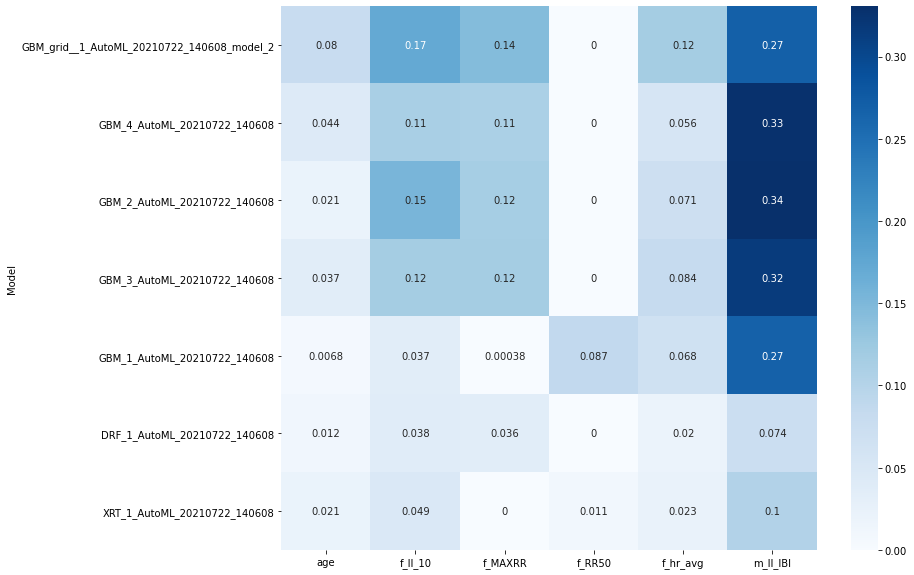

In [36]:
fig, ax = plt.subplots(figsize=(12,10))

# Filtering values
top_coefs = df_imp.loc[df_imp.max(axis=1) > 0.05, df_imp.max(axis=0) > 0.05]

sns.heatmap(top_coefs, robust=True, annot=True, cmap="Blues")
plt.savefig('heatmap_clf_automl_10fold.png',bbox_inches="tight")
plt.show()

#### Feature Importances of top 3 models

GLM_1_AutoML_20210722_140608


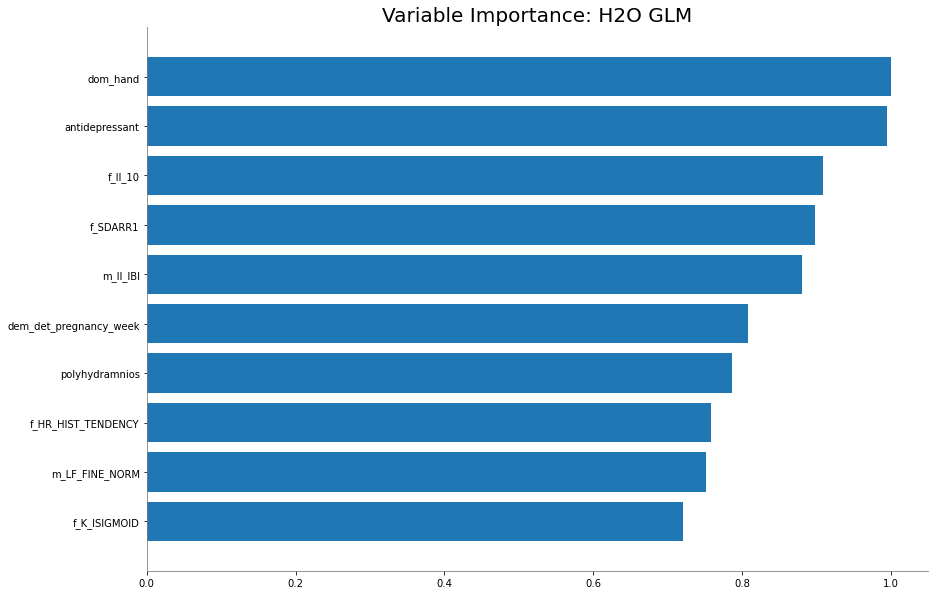

GBM_grid__1_AutoML_20210722_140608_model_2


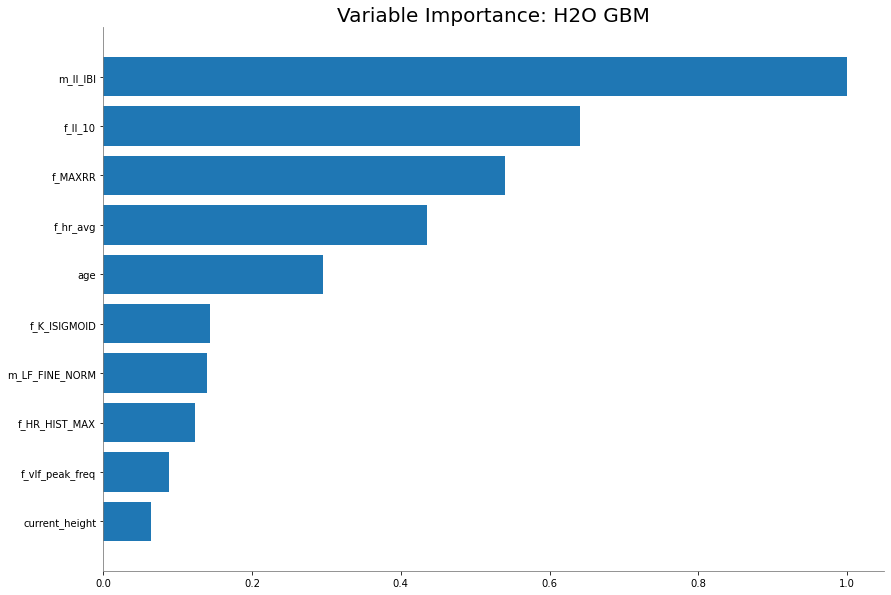

GBM_4_AutoML_20210722_140608


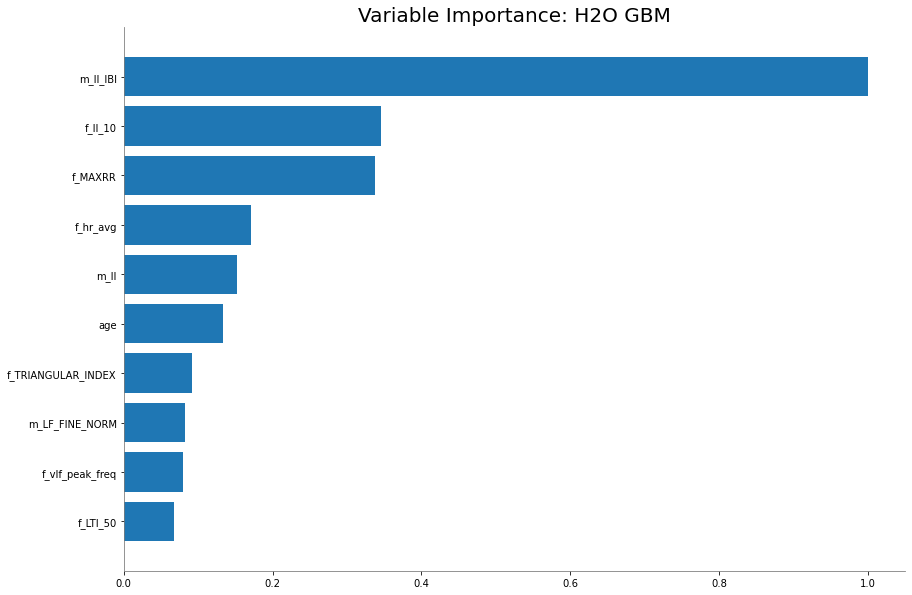

In [23]:
for i in range(3):
    m_id = leaderboard.iloc[i]['model_id']
    print(m_id)
    model = h2o.get_model(m_id)
    model.varimp_plot()

In [24]:
for i in range(3):
    m_id = leaderboard.iloc[i]['model_id']
    print(m_id)
    model = h2o.get_model(m_id)
    print(model.cross_validation_metrics_summary())

GLM_1_AutoML_20210722_140608

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,accuracy,0.515,0.39864352,0.4,0.6,0.6,0.0,0.8,0.0,0.0,1.0,1.0,0.75
1,auc,0.63095236,0.30374646,0.16666667,0.5,0.5,NaN,0.75,NaN,NaN,1.0,1.0,0.5
2,err,0.21744294,0.21299787,0.6,0.4,0.4,0.001177337,0.2,0.31390834,0.009343761,0.0,0.0,0.25
3,err_count,1.2857143,1.1126972,3.0,2.0,2.0,NaN,1.0,NaN,NaN,0.0,0.0,1.0
4,f0point5,0.45667937,0.37134337,0.45454547,0.3846154,0.3846154,3.3104473E-6,0.5555556,0.0728553,3.1769276E-4,1.0,1.0,0.71428573
5,f1,1.4148568,1.1333177,0.5714286,0.5,0.5,3.0368242,0.6666667,3.0368242,3.0368242,1.0,1.0,0.8
6,f2,0.59402263,0.4222145,0.7692308,0.71428573,0.71428573,0.0,0.8333333,0.0,0.0,1.0,1.0,0.90909094
7,lift_top_group,-Infinity,NaN,0.0,0.0,0.0,-Infinity,0.0,-Infinity,-Infinity,4.0,1.3333334,0.0
8,logloss,0.75890315,0.893652,0.76843363,0.44401723,0.50369775,0.01177337,0.3308865,3.1390834,0.09343761,0.44035667,1.0139165,0.84342873
9,max_per_class_error,0.30395606,0.32690185,1.0,0.5,0.5,0.0018194634,0.25,0.26991722,0.017823936,0.0,0.0,0.5



See the whole table with table.as_data_frame()

GBM_grid__1_AutoML_20210722_140608_model_2

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,accuracy,0.59,0.44334587,0.8,1.0,0.6,0.0,1.0,0.0,0.0,1.0,1.0,0.5
1,auc,0.7380952,0.38317803,0.6666667,1.0,0.5,NaN,1.0,NaN,NaN,1.0,1.0,0.0
2,err,0.19266248,0.19424787,0.2,0.0,0.4,0.4183637,0.0,0.16940537,0.23885566,0.0,0.0,0.5
3,err_count,0.71428573,0.95118976,1.0,0.0,2.0,NaN,0.0,NaN,NaN,0.0,0.0,2.0
4,f0point5,0.5878043,0.41272834,0.71428573,1.0,0.3846154,0.12936412,1.0,0.035021257,0.05920122,1.0,1.0,0.5555556
5,f1,0.5966667,0.44401368,0.8,1.0,0.5,0.0,1.0,0.0,0.0,1.0,1.0,0.6666667
6,f2,-Infinity,NaN,0.90909094,1.0,0.71428573,-Infinity,1.0,-Infinity,-Infinity,1.0,1.0,0.8333333
7,lift_top_group,1.6123458,2.1603696,0.0,5.0,0.0,0.35967222,5.0,0.18713968,0.243313,4.0,1.3333334,0.0
8,logloss,0.40423706,0.44118714,0.69817936,0.23703648,0.49555498,None,0.34232545,None,None,0.04822098,1.0376419,1.1834115
9,max_per_class_error,0.18333334,0.3374743,0.33333334,0.0,0.5,None,0.0,None,None,0.0,0.0,1.0



GBM_4_AutoML_20210722_140608

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,accuracy,0.65,0.47434166,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.5
1,auc,0.89285713,0.28347334,1.0,1.0,1.0,NaN,1.0,NaN,NaN,1.0,1.0,0.25
2,err,0.15160531,0.21102649,0.0,0.0,0.0,0.26875648,0.0,0.25286925,0.49442732,0.0,0.0,0.5
3,err_count,0.2857143,0.75592893,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,2.0
4,f0point5,0.6882325,0.42361757,1.0,1.0,1.0,0.0751097,1.0,0.07218096,0.17947851,1.0,1.0,0.5555556
5,f1,0.6666667,0.47140452,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.6666667
6,f2,-Infinity,NaN,1.0,1.0,1.0,-Infinity,1.0,-Infinity,-Infinity,1.0,1.0,0.8333333
7,lift_top_group,2.3799708,2.178479,2.5,5.0,5.0,0.2740615,5.0,0.26866513,0.42364904,4.0,1.3333334,0.0
8,logloss,0.44257915,0.50985885,0.5165036,0.34644902,0.40296784,None,0.19971174,None,None,0.27784258,1.2094615,1.4728554
9,max_per_class_error,0.1,0.31622776,0.0,0.0,0.0,None,0.0,None,None,0.0,0.0,1.0


#### Saving coefficients of top model to csv

In [25]:
top_clf_coefs = top_model_proc_ten.varimp()

top_clf_coefs_df = pd.DataFrame(top_clf_coefs, columns = 
                                ['variable', 'relative_importance', 'scaled_importance', 'percentage'])

top_clf_coefs_df.to_csv('Top_AutoML_Classifier_Coefficients_10_fold(Processed_Data).csv')

#### Combining results of both K-Fold (5 and 10) CV to one dataframe:

In [26]:
top_model_proc_cv_metrics.insert(1, 'K-Fold', 5)
top_model_proc_ten_cv_metrics.insert(1, 'K-Fold', 10)

top_model_proc_cv_metrics.insert(2, 'model', top_model_proc.model_id)
top_model_proc_ten_cv_metrics.insert(2, 'model', top_model_proc_ten.model_id)

combined = pd.concat([top_model_proc_cv_metrics,top_model_proc_ten_cv_metrics], axis=0)
combined.columns = ["metric", "K-Fold", 'model', "mean", "sd", "cv_1_valid", "cv_2_valid", "cv_3_valid", "cv_4_valid", "cv_5_valid",
                   "cv_6_valid", "cv_7_valid", "cv_8_valid", "cv_9_valid", "cv_10_valid"]
combined = combined.set_index(["metric", "model"]).sort_values(by='metric')
combined

K-Fold          mean  \
metric                  model                                                
accuracy                GLM_1_AutoML_20210722_140502       5    0.77111113   
                        GLM_1_AutoML_20210722_140608      10         0.515   
auc                     GLM_1_AutoML_20210722_140502       5    0.70357144   
                        GLM_1_AutoML_20210722_140608      10    0.63095236   
err                     GLM_1_AutoML_20210722_140502       5    0.22888888   
                        GLM_1_AutoML_20210722_140608      10    0.21744294   
err_count               GLM_1_AutoML_20210722_140502       5           2.2   
                        GLM_1_AutoML_20210722_140608      10     1.2857143   
f0point5                GLM_1_AutoML_20210722_140502       5     0.6249308   
                        GLM_1_AutoML_20210722_140608      10    0.45667937   
f1                      GLM_1_AutoML_20210722_140502       5    0.66809523   
                        GLM_1_AutoML_20210722_140608      10     1.4148568   
f2                      GLM_1_AutoML_20210722_140502       5    0.76674837   
                        GLM_1_AutoML_20210722_140608      10    0.59402263   
lift_top_group          GLM_1_AutoML_20210722_140608      10     -Infinity   
                        GLM_1_AutoML_20210722_140502       5           1.5   
logloss                 GLM_1_AutoML_20210722_140608      10    0.75890315   
                        GLM_1_AutoML_20210722_140502       5     0.4592033   
max_per_class_error     GLM_1_AutoML_20210722_140608      10    0.30395606   
                        GLM_1_AutoML_20210722_140502       5    0.37222221   
mcc                     GLM_1_AutoML_20210722_140608      10    0.44513547   
                        GLM_1_AutoML_20210722_140502       5    0.60022587   
mean_per_class_accuracy GLM_1_AutoML_20210722_140608      10        0.5625   
                        GLM_1_AutoML_20210722_140502       5     0.8138889   
mean_per_class_error    GLM_1_AutoML_20210722_140608      10        0.1375   
                        GLM_1_AutoML_20210722_140502       5    0.18611111   
mse                     GLM_1_AutoML_20210722_140608      10    0.14386518   
                        GLM_1_AutoML_20210722_140502       5    0.14890286   
null_deviance           GLM_1_AutoML_20210722_140608      10      4.494857   
                        GLM_1_AutoML_20210722_140502       5     10.463778   
pr_auc                  GLM_1_AutoML_20210722_140608      10    0.33955058   
                        GLM_1_AutoML_20210722_140502       5    0.47356805   
precision               GLM_1_AutoML_20210722_140502       5          0.62   
                        GLM_1_AutoML_20210722_140608      10    0.42333335   
r2                      GLM_1_AutoML_20210722_140608      10  -0.029974278   
                        GLM_1_AutoML_20210722_140502       5    0.12754808   
recall                  GLM_1_AutoML_20210722_140608      10           0.7   
                        GLM_1_AutoML_20210722_140502       5           0.9   
residual_deviance       GLM_1_AutoML_20210722_140608      10     3.8851967   
                        GLM_1_AutoML_20210722_140502       5      8.569963   
rmse                    GLM_1_AutoML_20210722_140608      10    0.31127396   
                        GLM_1_AutoML_20210722_140502       5    0.38057175   
specificity             GLM_1_AutoML_20210722_140502       5     0.7277778   
                        GLM_1_AutoML_20210722_140608      10         0.425   

                                                               sd  \
metric                  model                                       
accuracy                GLM_1_AutoML_20210722_140502   0.21337962   
                        GLM_1_AutoML_20210722_140608   0.39864352   
auc                     GLM_1_AutoML_20210722_140502    0.2265887   
                        GLM_1_AutoML_20210722_140608   0.30374646   
err                     GLM_1_AutoML_20210722_14050

In [27]:
combined.to_csv('Top_AutoML_Classifiers_CV_Results_combined(Processed_baseline_data).csv')

#### Testing top model hyper-parameters (of 5-Fold CV auto-ML) with Sklearn:

In [28]:
tmp_feat_arr = top_model_proc.varimp()

feat_lst = []

for coef in tmp_feat_arr:
    if coef[1] != 0:
        feat_lst.append(coef[0])

X = df_feats.drop(columns=['study_id'])
y = df_targets["cesdclinmA"]

X = X[feat_lst]

scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns = X.columns)

clf_test = GradientBoostingClassifier(n_estimators=63, max_depth=3, min_samples_leaf=2, max_leaf_nodes=4, random_state=0)

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

avg = 0

# cross-validating
for ind, (train_index, val_index) in enumerate(skf.split(X, y)):
    
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    clf_test.fit(X_train, y_train)
    
    train_acc = clf_test.score(X_train, y_train)
    acc = clf_test.score(X_val, y_val)
    
    avg += acc
    
    print(f'{ind+1}-fold:  test accuracy = {acc}, train accuracy = {train_acc}')

print(f' CV accuracy = {round(avg/10, 4)}')

1-fold:  test accuracy = 0.4, train accuracy = 1.0
2-fold:  test accuracy = 0.5, train accuracy = 1.0
3-fold:  test accuracy = 0.6666666666666666, train accuracy = 1.0
4-fold:  test accuracy = 0.4444444444444444, train accuracy = 1.0
5-fold:  test accuracy = 0.7777777777777778, train accuracy = 1.0
 CV accuracy = 0.2789


#### Feature Importance

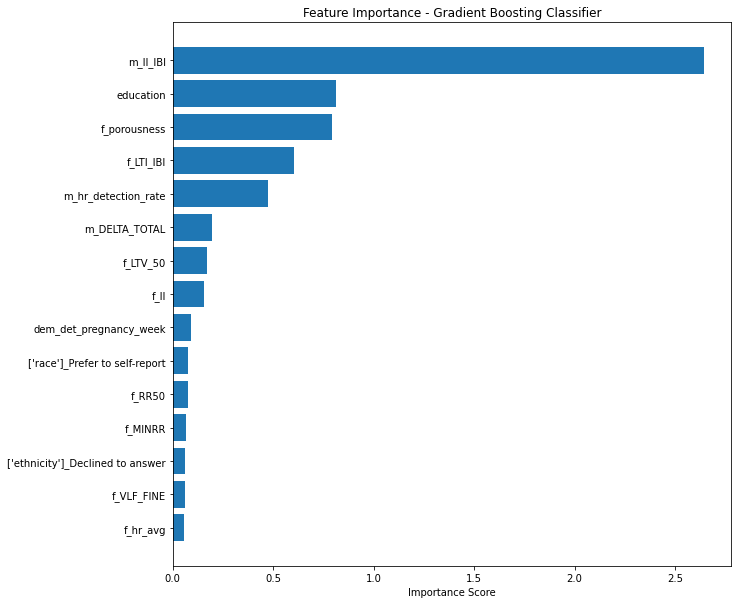

In [29]:
coef_df = pd.DataFrame(clf_test.feature_importances_, index = feat_lst, columns = ['Coefficient']).sort_values(by='Coefficient')

err = [(X[feat].std()/np.sqrt(len(X))) for feat in feat_lst]

coef_df['err'] = err

coef_df['t'] = coef_df['Coefficient'] / coef_df['err']

top_coef = coef_df.sort_values(by='t', ascending=False)[0:15]

plt.figure(figsize=(10,10))
plt.barh(top_coef.index, top_coef['t'])
plt.gca().invert_yaxis()
plt.title("Feature Importance - Gradient Boosting Classifier")
plt.xlabel('Importance Score');

#### Testing top model hyper-parameters (of 10-Fold CV auto-ML) with Sklearn:

In [30]:
tmp_feat_arr = top_model_proc_ten.varimp()

feat_lst = []

for coef in tmp_feat_arr:
    if coef[1] != 0:
        feat_lst.append(coef[0])

X = df_feats.drop(columns=['study_id'])
y = df_targets["cesdclinmA"]

X = X[feat_lst]

scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns = X.columns)

clf_test = GradientBoostingClassifier(n_estimators=87, max_depth=3, min_samples_leaf=2, max_leaf_nodes=4, random_state=0)

skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

avg = 0

# cross-validating
for ind, (train_index, val_index) in enumerate(skf.split(X, y)):
    
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    clf_test.fit(X_train, y_train)
    
    train_acc = clf_test.score(X_train, y_train)
    acc = clf_test.score(X_val, y_val)
    
    avg += acc
    
    print(f'{ind+1}-fold:  test accuracy = {acc}, train accuracy = {train_acc}')

print(f' CV accuracy = {round(avg/10, 4)}')

1-fold:  test accuracy = 0.8, train accuracy = 1.0
2-fold:  test accuracy = 0.2, train accuracy = 1.0
3-fold:  test accuracy = 0.4, train accuracy = 1.0
4-fold:  test accuracy = 0.4, train accuracy = 1.0
5-fold:  test accuracy = 0.8, train accuracy = 1.0
6-fold:  test accuracy = 0.8, train accuracy = 1.0
7-fold:  test accuracy = 0.6, train accuracy = 1.0
8-fold:  test accuracy = 0.75, train accuracy = 1.0
9-fold:  test accuracy = 0.75, train accuracy = 1.0
10-fold:  test accuracy = 0.75, train accuracy = 1.0
 CV accuracy = 0.625


#### Feature Importance

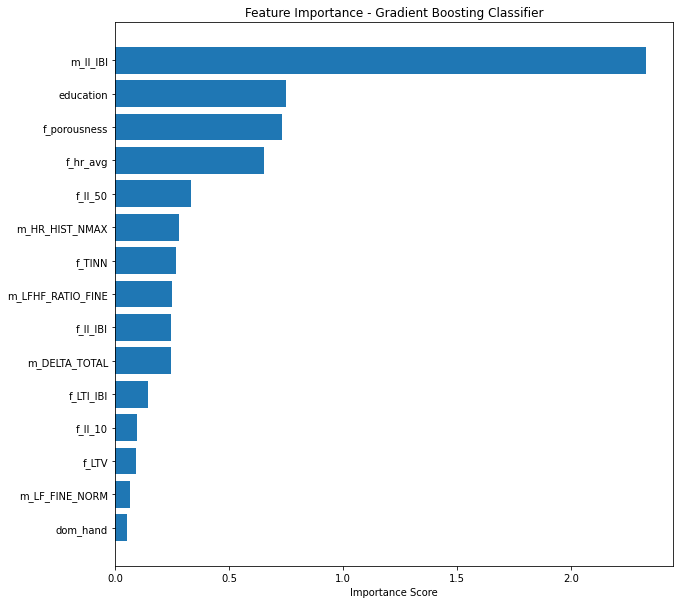

In [31]:
coef_df = pd.DataFrame(clf_test.feature_importances_, index = feat_lst, columns = ['Coefficient']).sort_values(by='Coefficient')

err = [(X[feat].std()/np.sqrt(len(X))) for feat in feat_lst]

coef_df['err'] = err

coef_df['t'] = coef_df['Coefficient'] / coef_df['err']

top_coef = coef_df.sort_values(by='t', ascending=False)[0:15]

plt.figure(figsize=(10,10))
plt.barh(top_coef.index, top_coef['t'])
plt.gca().invert_yaxis()
plt.title("Feature Importance - Gradient Boosting Classifier")
plt.xlabel('Importance Score');

## Regression

### On processed data:

In [32]:
X = df_feats.drop(columns=['study_id'])

df_auto = pd.concat([X, df_targets["psatotmA"]], axis=1)

# converting to h20 data object
df_h2o_reg = h2o.H2OFrame(df_auto)

y = "psatotmA"

aml_proc_reg = H2OAutoML(max_models = 10, seed = 1, nfolds=5, sort_metric='rmse', keep_cross_validation_predictions=True)

aml_proc_reg.train(y = y, training_frame = df_h2o_reg)

aml_proc_reg.leaderboard.head()

Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
14:07:18.508: AutoML: XGBoost is not available; skipping it.

████████
14:07:24.557: Skipping training of model GBM_5_AutoML_20210722_140718 due to exception: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_5_AutoML_20210722_140718.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 47.0.


████████████████████████████████████████████████| 100%


model_id,rmse,mean_residual_deviance,mse,mae,rmsle
GLM_1_AutoML_20210722_140718,4.74169,22.4837,22.4837,3.15318,0.211693
StackedEnsemble_BestOfFamily_AutoML_20210722_140718,4.81361,23.1709,23.1709,3.13988,0.21464
GBM_2_AutoML_20210722_140718,5.0173,25.1733,25.1733,3.65229,0.2325
GBM_4_AutoML_20210722_140718,5.02877,25.2885,25.2885,3.67537,0.232003
GBM_3_AutoML_20210722_140718,5.04026,25.4042,25.4042,3.71186,0.232882
GBM_grid__1_AutoML_20210722_140718_model_1,5.1378,26.397,26.397,3.7378,0.23699
DeepLearning_grid__1_AutoML_20210722_140718_model_1,5.27595,27.8356,27.8356,3.63641,0.238848
StackedEnsemble_AllModels_AutoML_20210722_140718,5.35282,28.6527,28.6527,3.65069,0.243773
XRT_1_AutoML_20210722_140718,5.35811,28.7093,28.7093,3.59737,0.243235
GBM_1_AutoML_20210722_140718,5.6256,31.6474,31.6474,3.81818,0.25356


#### Top Model:

In [33]:
top_model_proc_reg = aml_proc_reg.leader
top_model_proc_reg.summary()


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,Ridge ( lambda = 139.51 ),"nlambda = 30, lambda.max = 191.67, lambda.min = 139.51, lambda.1se...",175,175,2,automl_training_Key_Frame__upload_8e42c1782c93b5ca181be2dc23cc4211...


#### Top Model CV Results (+Saving to csv):

In [34]:
top_model_cv_metrics = top_model_proc_reg.cross_validation_metrics_summary().as_data_frame()
top_model_cv_metrics.to_csv('Top_AutoML_Regressor_CV_Results.csv')
top_model_cv_metrics

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,3.0808296,1.3216485,4.7261224,2.0420773,1.4912974,3.8815782,3.2630732
1,mean_residual_deviance,21.479027,16.810732,44.33105,6.5453243,3.2579968,26.84668,26.414082
2,mse,21.479027,16.810732,44.33105,6.5453243,3.2579968,26.84668,26.414082
3,null_deviance,211.52864,166.11035,439.62088,63.74945,34.25,246.28255,273.7403
4,r2,-0.10554086,0.3028754,-0.014672702,-0.6322505,0.14318913,0.018690888,-0.042661093
5,residual_deviance,203.48651,165.47551,443.31052,65.45325,29.321972,241.62012,237.72673
6,rmse,4.2684746,2.0184,6.658157,2.5583832,1.8049922,5.181378,5.139463
7,rmsle,0.195616,0.074247316,0.27763653,0.14170933,0.099296264,0.24989125,0.20954667


#### Top Model - Feature Importance

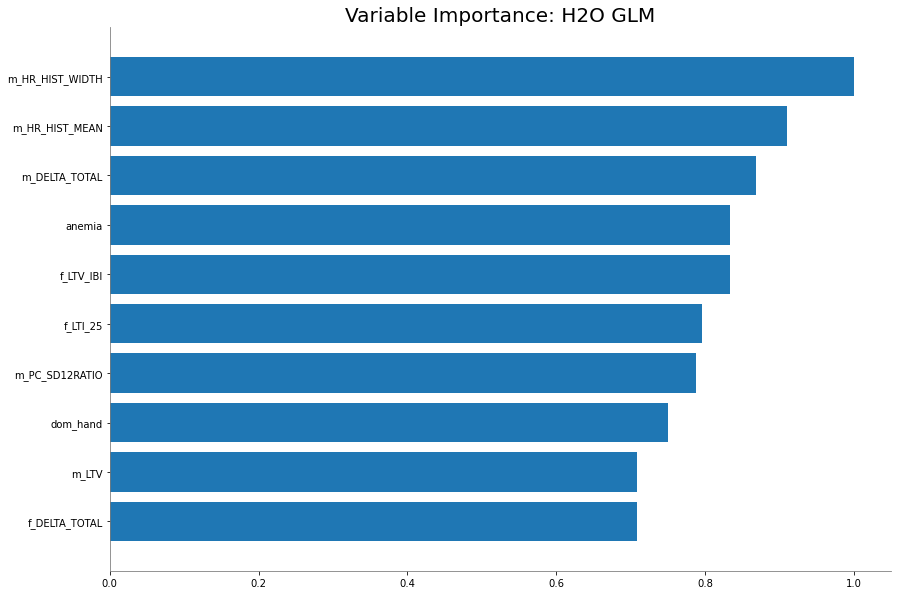

In [40]:
top_model_proc_reg.varimp_plot()

#### And saving coefficients to csv

In [ ]:
top_reg_coefs = top_model_orig_reg.varimp()
top_reg_coefs_df = pd.DataFrame(top_reg_coefs, columns = ['variable', 'relative_importance', 'scaled_importance', 'percentage'])
top_reg_coefs_df.to_csv('Top_AutoML_Regressor_Coefficients.csv')